In [1]:
import pickle
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory, mappability_threshold, normalization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

# Ensure resolutions is treated as a tuple or list of strings

if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging 
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]

# Debug print to check the value of resolution_str
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, resolution_label = parse_resolution(resolution_str)

# Load original_bulk_data from the file
bulk_data_input_file = '../../projects/single_cell_files/nan_removed_bulk_data.pkl'
with open(bulk_data_input_file, 'rb') as f:
    bulk_data = pickle.load(f)
print(f"bulk_data loaded from {bulk_data_input_file}")

# Load original_bulk_data from the file
original_bulk_data_input_file = '../../projects/single_cell_files/original_bulk_data.pkl'
with open(original_bulk_data_input_file, 'rb') as f:
    original_bulk_data = pickle.load(f)
print(f"original_bulk_data loaded from {bulk_data_input_file}")

# Load chromosome_results from the file
chromosome_results_input_file = '../../projects/single_cell_files/chromosome_results.pkl'
with open(chromosome_results_input_file, 'rb') as f:
    chromosome_results = pickle.load(f)
print(f"chromosome_results loaded from {chromosome_results_input_file}")

########################################################################
#compute the genome-wide correlation of the two AB compartment cell types
# should be somehting like .6 if all the above steps were done correctly
# this is a sanity check
# There seems to be a problem here
# I beleive the issue is that without KR normalization, 
# the genome wide correlation of bulk is not that high
########################################################################
# Initialize lists to collect the eigenvector values for IMR90 and GM12878
imr90_values = []
gm12878_values = []

# Loop through each chromosome
for i in range(1, 23):
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_{normalization}_eigenvector'
    key_imr90 = f'res{resolution}_ch{i}_oe_IMR90_{normalization}_eigenvector'                                                               
                                                               
    # Check if the keys exist in the data to avoid KeyErrors
    if key_gm12878 in bulk_data and key_imr90 in bulk_data:
        # Extend the list with the eigenvector values from each chromosome
        # Ensure values are numeric (floats or ints)
        gm12878_vals = bulk_data[key_gm12878]['eigenvalue']
        imr90_vals = bulk_data[key_imr90]['eigenvalue']
        imr90_values.extend(imr90_vals)
        gm12878_values.extend(gm12878_vals)
        
# Convert lists to pandas Series for correlation calculation
imr90_series = pd.Series(imr90_values)
gm12878_series = pd.Series(gm12878_values)

# Calculate the Pearson correlation coefficient between IMR90 and GM12878
correlation = imr90_series.corr(gm12878_series)

print(f'Genome-wide correlation between IMR90 and GM12878: {correlation}')



bam_directory='/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/filesFromCluster/bam'
methy_directory='/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/filesFromCluster/bam/methylation/filter_low_qual'
software_directory='../../bin/softwarefiles'
chrom_file='../../bin/softwarefiles/hg19.autosome.chrom.sizes'
fragments_file='../../bin/softwarefiles/hg19_DpnII.txt'
output_directory='../../projects/single_cell_files'
hg19_fa_url='ftp://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz'
filtered_list='../../projects/single_cell_files/filtered_bam_list.txt'
schicluster_env='schicluster2'
bisulfite_env='bisulfitehic27'
min_high_quality_reads='250000'
resolutions='1000000:1Mb'
impute='False'
cluster_compartments='False'
cumulant='False'
iterations='400'
chromosomes=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
dark_regions_hg19_url='https://www.encodeproject.org/files/ENCFF000EHJ/@@download/ENCFF000EHJ.bigWig'
mappability_threshold='0.6'
data_type='

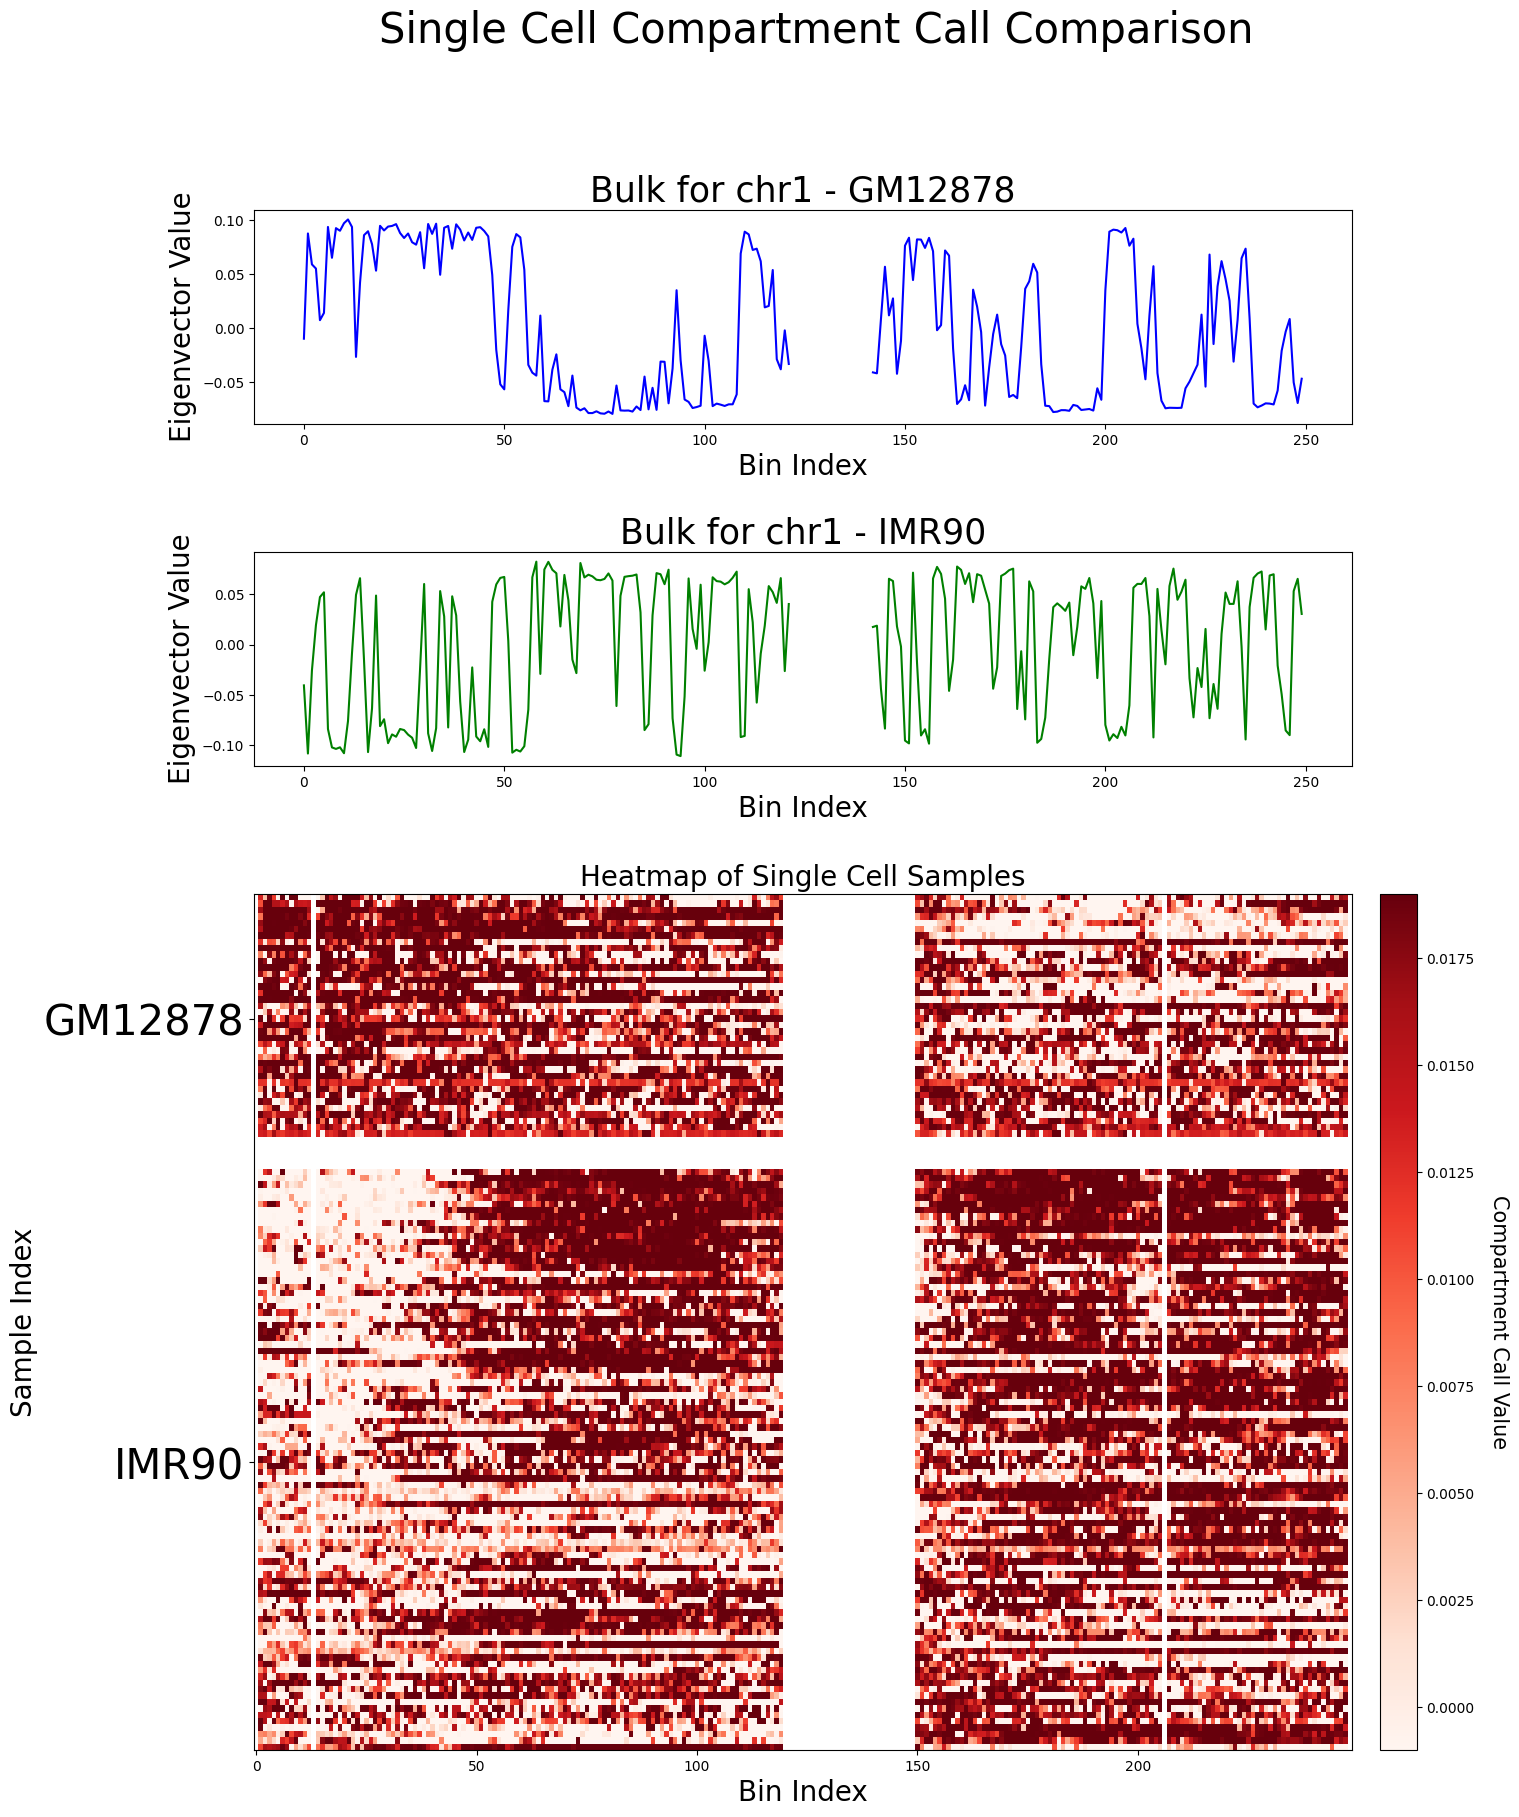

In [2]:
# Define the bulk eigenvectors
bulk_eigenvector_gm12878 = original_bulk_data[f'res1000000_ch1_oe_GM12878_{normalization}_eigenvector']['eigenvalue'].values
bulk_eigenvector_imr90 = original_bulk_data[f'res1000000_ch1_oe_IMR90_{normalization}_eigenvector']['eigenvalue'].values

# Generate the plot
chr=1    
sc_dataframe = chromosome_results[f'chr{chr}']

# Sort and prepare the dataframe
sc_dataframe['Cell Type Sort'] = sc_dataframe['Cell Type'].map({'gm12878': 0, 'imr90': 1})
sc_dataframe = sc_dataframe.sort_values(by=['Cell Type Sort', 'Correlation With Bulk'], ascending=[True, False])
sc_dataframe.drop('Cell Type Sort', axis=1, inplace=True)

# Function to plot eigenvectors and heatmap
def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 20))
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='blue')
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=20)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='green')
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=20)

    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'gm12878']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'imr90']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap='Reds', interpolation='nearest')
    ax_sc.set_title("Heatmap of Single Cell Samples", fontsize=20)
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('Compartment Call Value', rotation=270, labelpad=25, fontsize=15)

    plt.suptitle(title, fontsize=30)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

# Example invocation
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    f"Bulk for chr{chr} - GM12878",
    f"Bulk for chr{chr} - IMR90",
    "Single Cell Compartment Call Comparison",
    save_path="../../files/AB_compartment_heatmap.png"
)


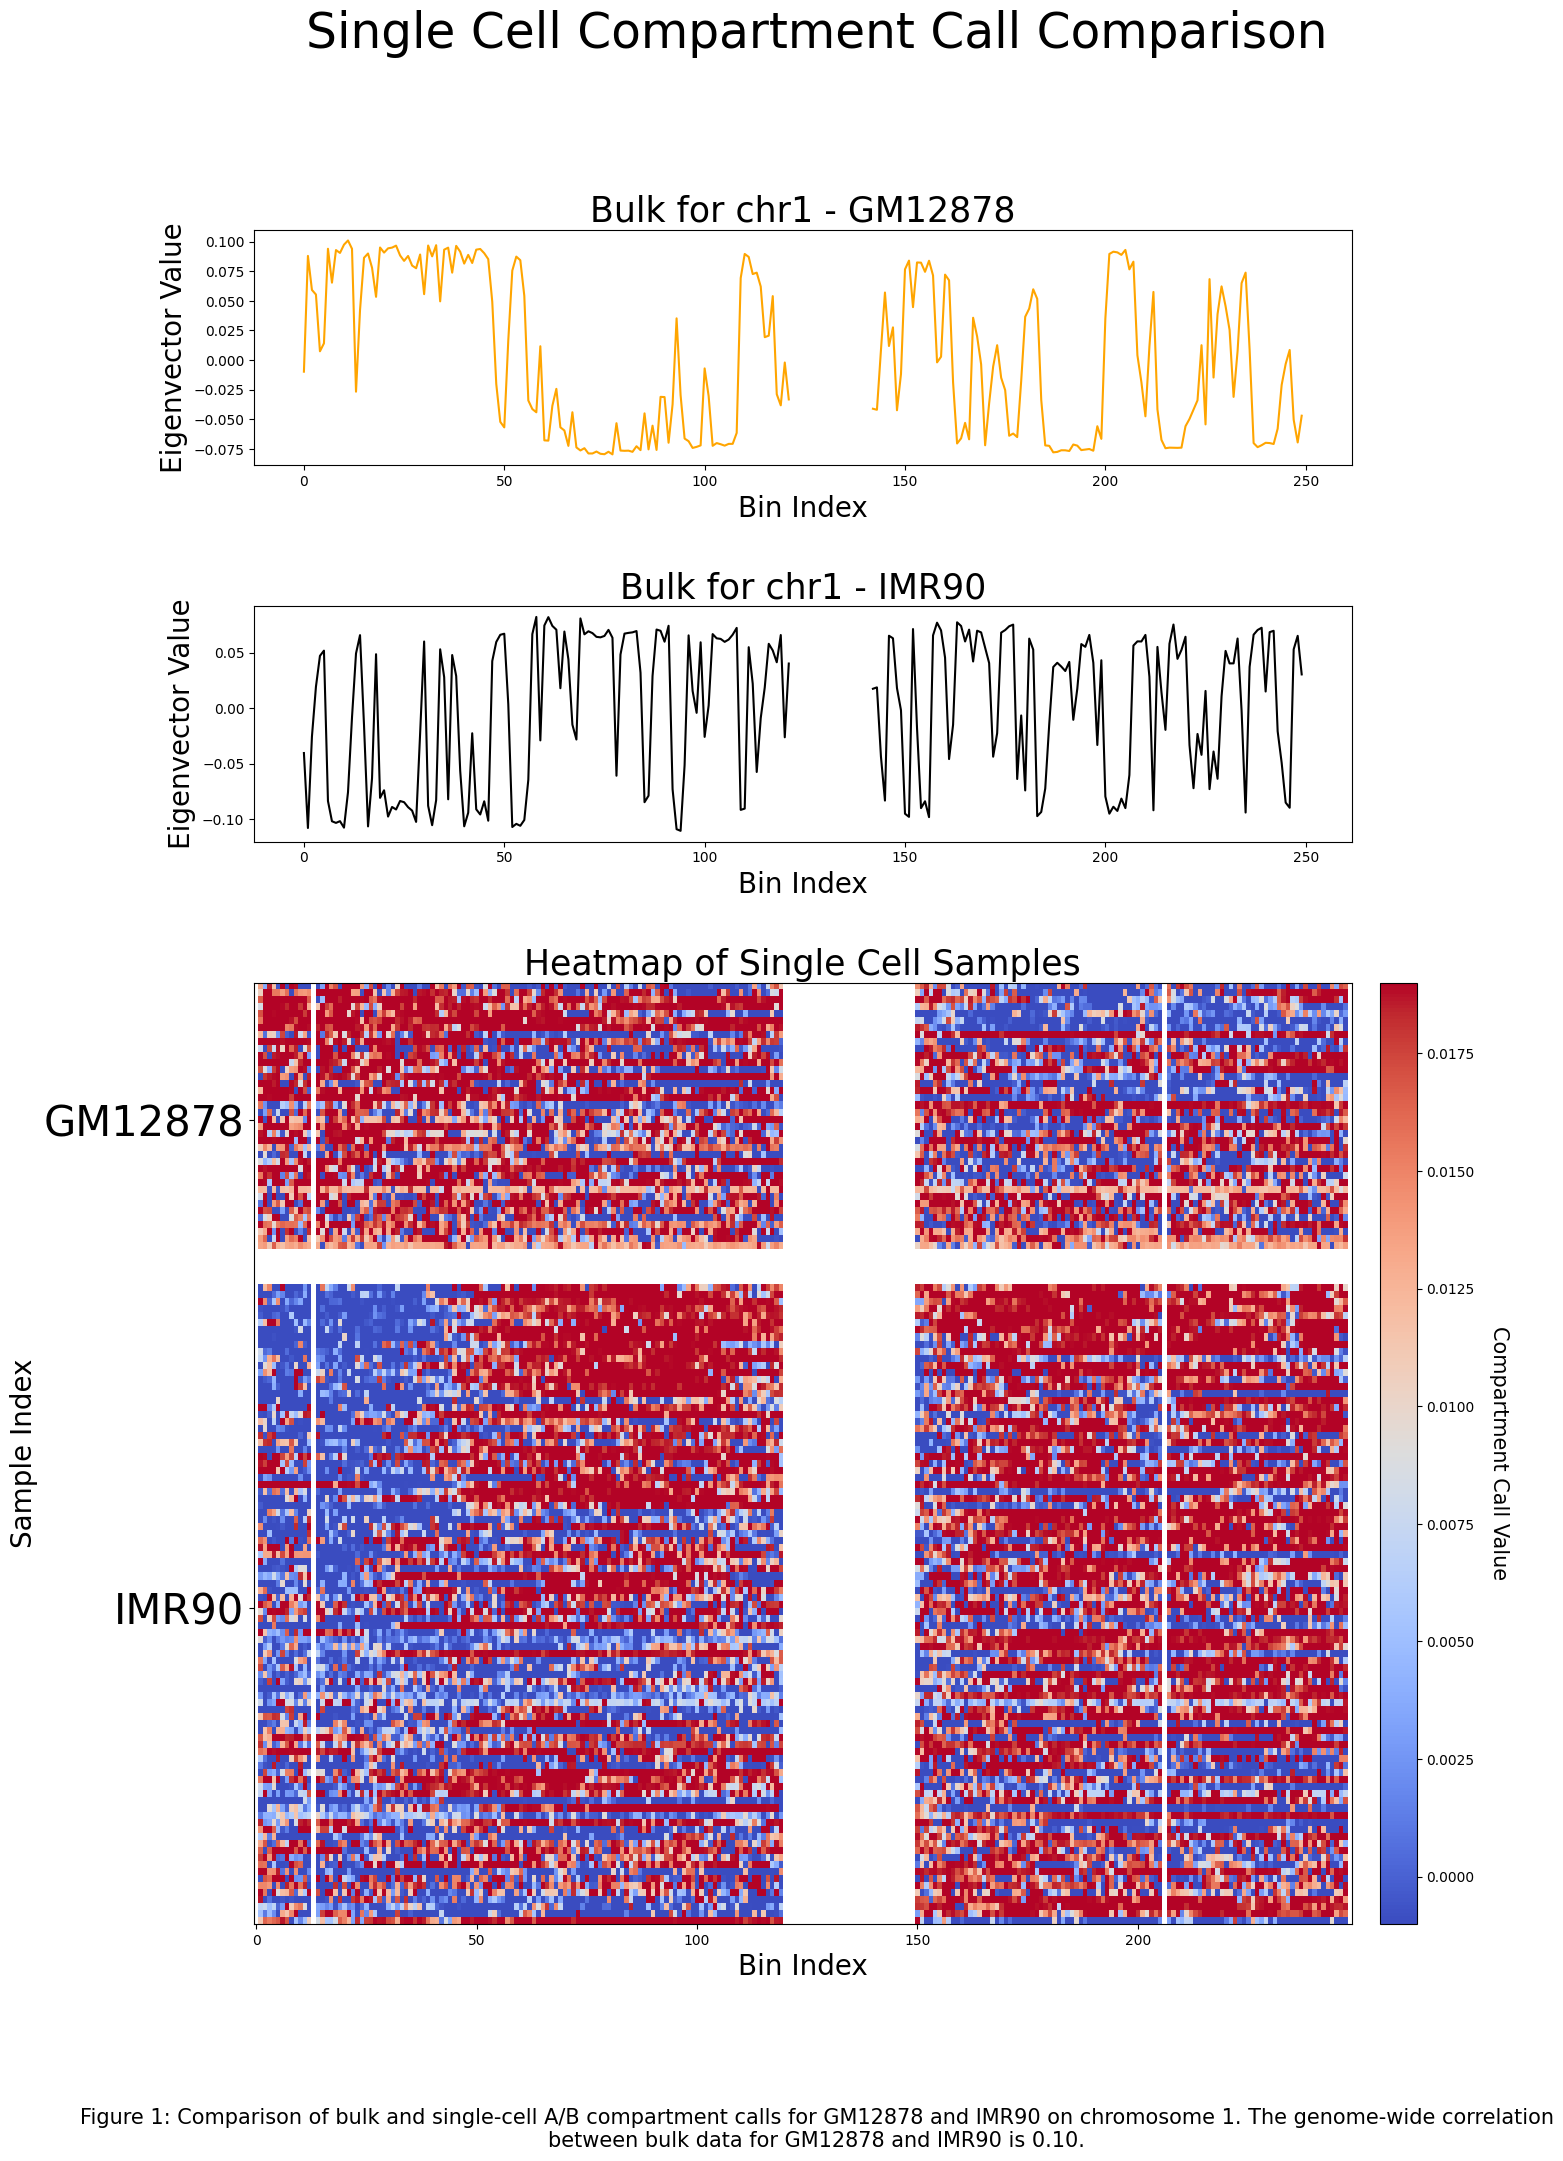

In [5]:
import os

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, correlation, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 22))  # Adjusted the figure size for better proportions
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='orange')
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=20)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='black')
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=20)

    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'gm12878']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'imr90']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap='coolwarm', interpolation='nearest')  # Changed colormap to 'coolwarm'
    ax_sc.set_title("Heatmap of Single Cell Samples", fontsize=25)  # Slightly larger font for the title
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('Compartment Call Value', rotation=270, labelpad=25, fontsize=15)

    plt.suptitle(title, fontsize=35)  # Increased the title font size

    # Construct the caption with the correlation value
    caption = f"Figure 1: Comparison of bulk and single-cell A/B compartment calls for GM12878 and IMR90 on chromosome 1. The genome-wide correlation between bulk data for GM12878 and IMR90 is {correlation:.2f}."

    # Add the caption at the bottom
    plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=15)

    if save_path:
        # Ensure the save directory exists
        save_directory = os.path.dirname(save_path)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

# Example invocation with the genome-wide correlation value
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    f"Bulk for chr{chr} - GM12878",
    f"Bulk for chr{chr} - IMR90",
    "Single Cell Compartment Call Comparison",
    correlation=correlation,  # Use the computed correlation value here
    save_path="../../files/AB_compartment_heatmap.png"
)


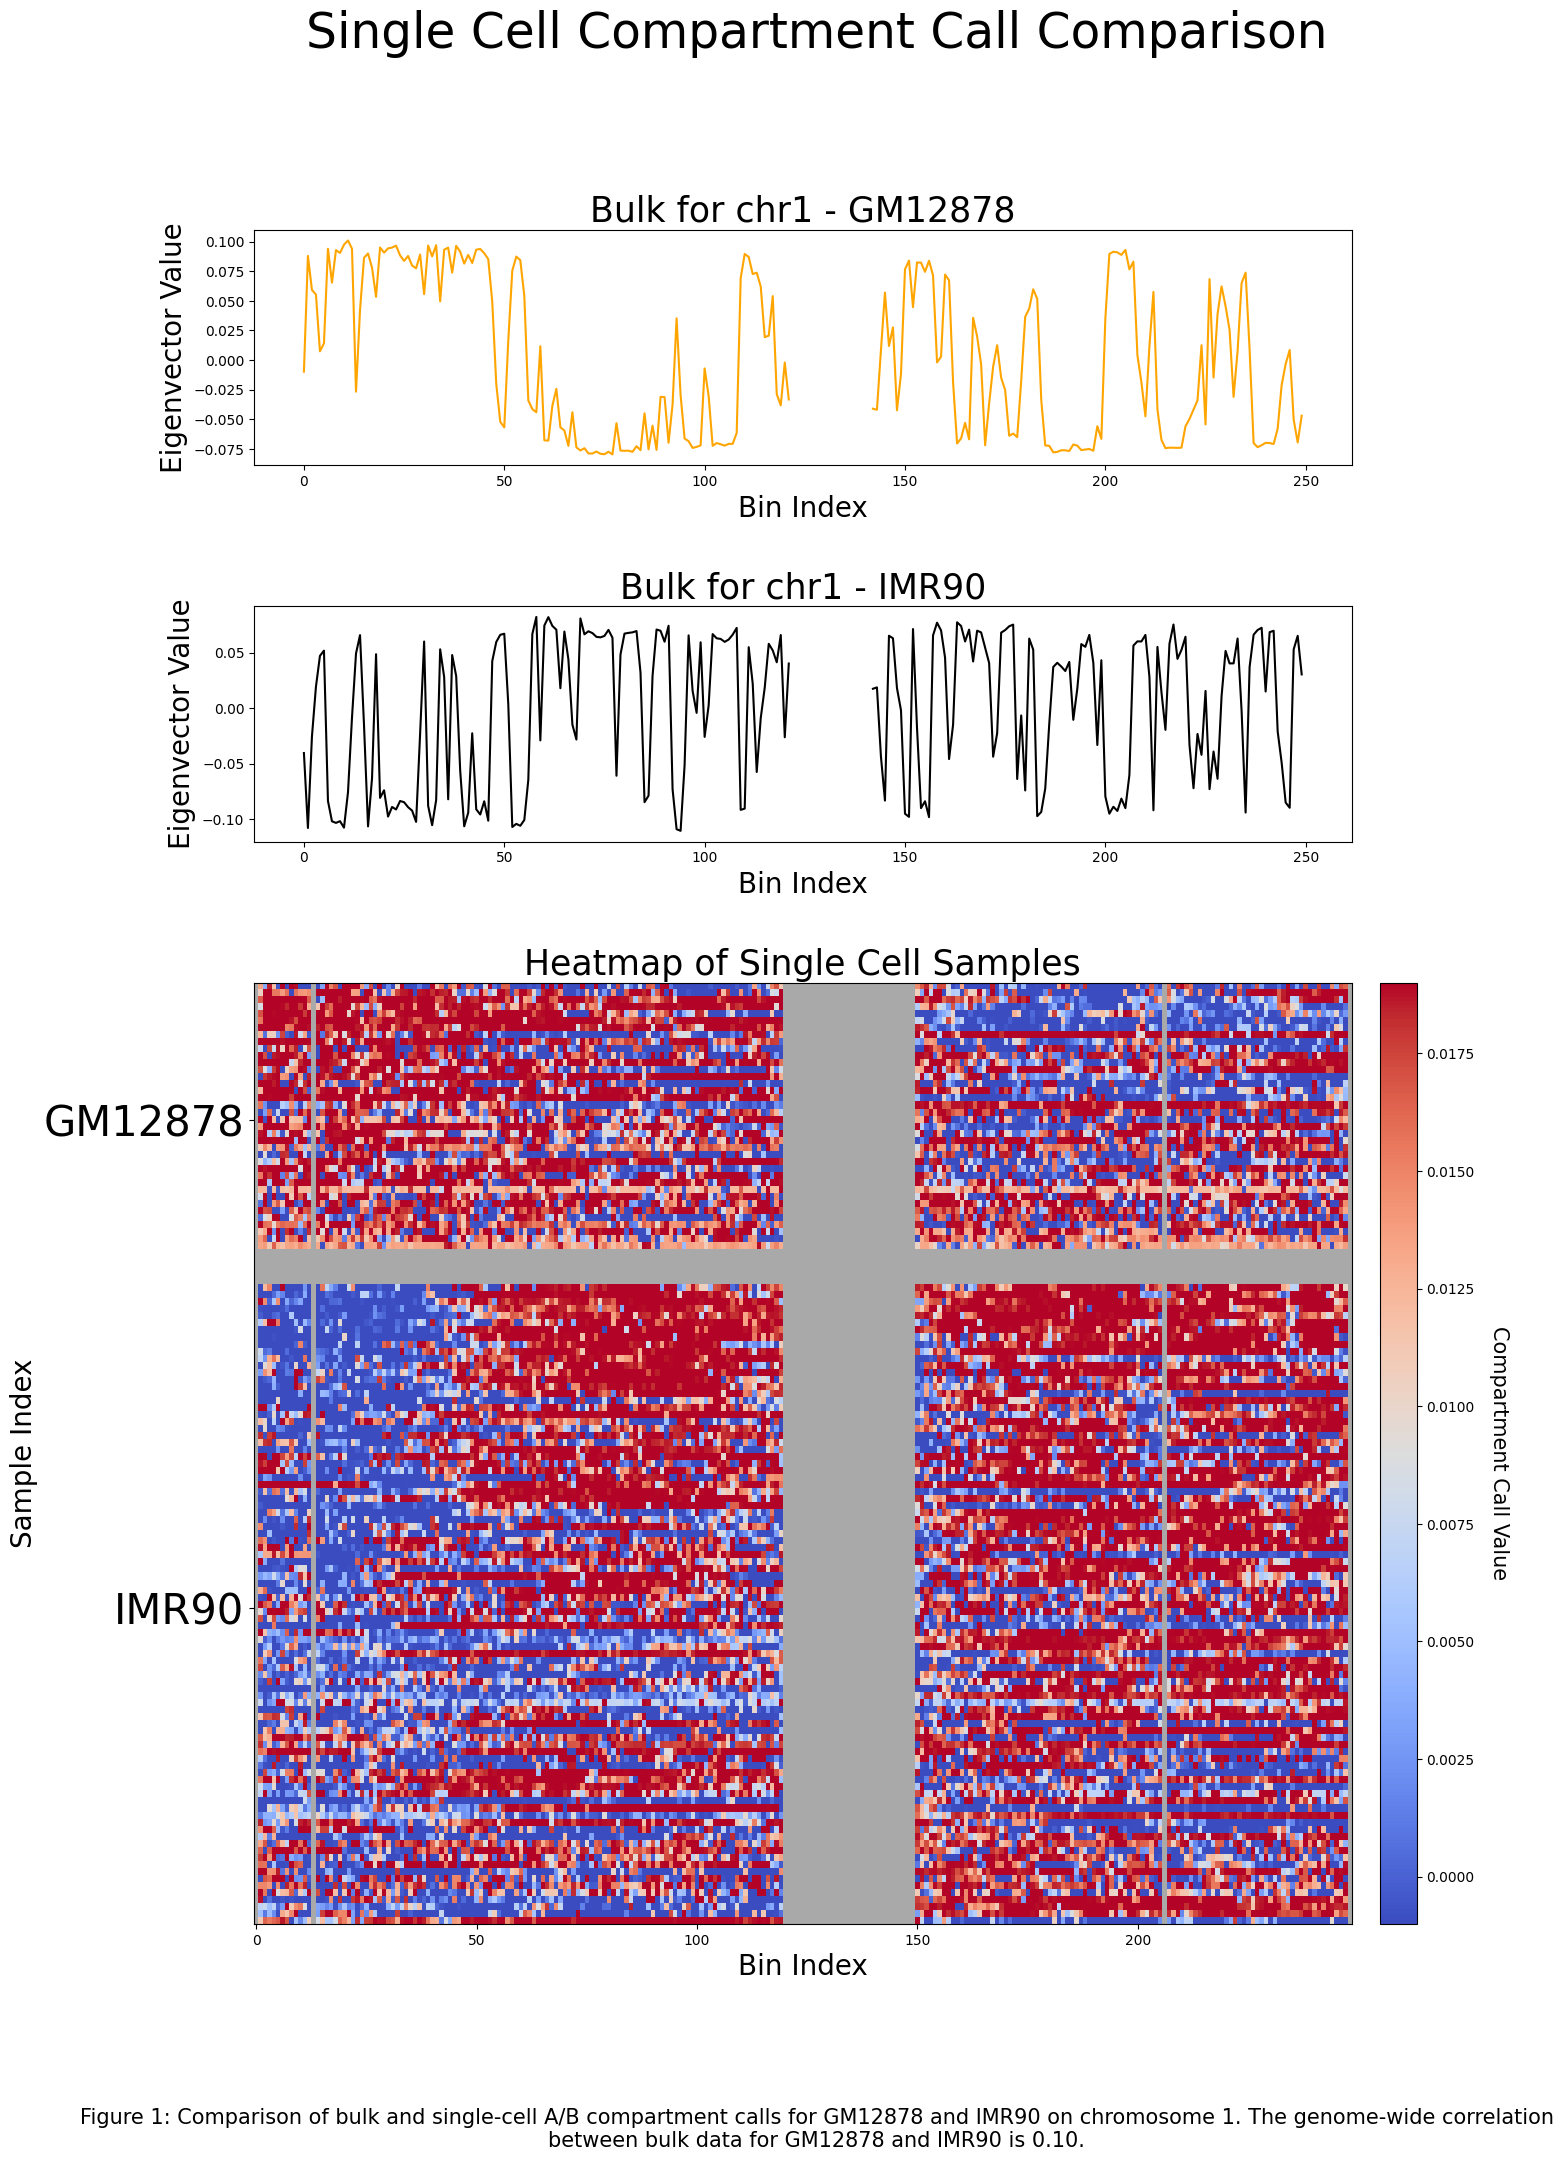

In [7]:
import os
import matplotlib.colors as mcolors

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, correlation, chr, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 22))  # Adjusted the figure size for better proportions
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='orange')
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=20)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='black')
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=20)

    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'gm12878']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'imr90']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    # Create a colormap that does not include white for NaN values
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='darkgrey')  # Set NaN color to light grey

    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap=cmap, interpolation='nearest')  # Use the adjusted colormap
    ax_sc.set_title("Heatmap of Single Cell Samples", fontsize=25)  # Slightly larger font for the title
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('Compartment Call Value', rotation=270, labelpad=25, fontsize=15)

    plt.suptitle(title, fontsize=35)  # Increased the title font size

    # Construct the caption with the chromosome number and correlation value
    caption = f"Figure 1: Comparison of bulk and single-cell A/B compartment calls for GM12878 and IMR90 on chromosome {chr}. The genome-wide correlation between bulk data for GM12878 and IMR90 is {correlation:.2f}."

    # Add the caption at the bottom
    plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=15)

    if save_path:
        # Ensure the save directory exists
        save_directory = os.path.dirname(save_path)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

# Example invocation with the genome-wide correlation value and chromosome number
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    f"Bulk for chr{chr} - GM12878",
    f"Bulk for chr{chr} - IMR90",
    "Single Cell Compartment Call Comparison",
    correlation=correlation,  # Use the computed correlation value here
    chr=chr,  # Use the chromosome number variable
    save_path="../../files/AB_compartment_heatmap.png"
)
